# 08 - Common problems & bad data situations

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

In this notebook, we will revise common problems that might come up when dealing with real-world data.

Maintainers: [@thempel](https://github.com/thempel), [@cwehmeyer](https://github.com/cwehmeyer), [@marscher](https://github.com/marscher), [@psolsson](https://github.com/psolsson)

**Remember**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA.org](http://www.pyemma.org).

---

Most problems in Markov modeling of MD data arise from bad sampling combined with a poor discretization.
For estimating a Markov model, it is required to have a connected data set,
i.e., we must have observed each process we want to describe in both directions.
PyEMMA checks if this requirement is fulfilled but, however, in certain situations this might be less obvious.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma

## Case 1: preprocessed, two-dimensional data (toy model)

### well-sampled double-well potential

Let's again have a look at the double-well potential.
Since we are only interested in the problematic situations here,
we will simplify our data a bit and work with a 1D projection.

In [2]:
file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = [fh['trajectory'][:, 1]]

Since this particular example is simple enough, we can define a plotting function that combines histograms with trajectory data:

In [3]:
def plot_1D_histogram_trajectories(data, cluster=None, max_traj_length=200, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for n, _traj in enumerate(data):
        ax.hist(_traj, bins=30, alpha=.33, density=True, color='C{}'.format(n));
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    for n, _traj in enumerate(data):
        ax.plot(
            _traj[:min(len(_traj), max_traj_length)], 
            np.linspace(*ylims, min(len(_traj), max_traj_length)), 
            alpha=0.6, color='C{}'.format(n), label='traj {}'.format(n))
        if cluster is not None:
            ax.plot(
                cluster.clustercenters[cluster.dtrajs[n][:min(len(_traj), max_traj_length)], 0], 
                np.linspace(*ylims, min(len(_traj), max_traj_length)), 
                '.-', alpha=.6, label='dtraj {}'.format(n), linewidth=.3)
    ax.annotate(
        '', xy=(0.8500001 * xlims[1], 0.7 * ylims[1]), xytext=(0.85 * xlims[1], 0.3 * ylims[1]),
        arrowprops=dict(fc='C0', ec='None', alpha=0.6, width=2))
    ax.text(0.86 * xlims[1], 0.5 * ylims[1], '$x(time)$', ha='left', va='center', rotation=90)
    ax.set_xlabel('TICA coordinate')
    ax.set_ylabel('histogram counts & trajectory time')
    ax.legend(loc=2)

As a reference, we visualize the histogram of this well-sampled trajectory along with the first $200$ steps (left panel) and the MSM implied timescales (right panel):

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_regspace". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.RegularSpace instead.
  return caller(func, *(extras + args), **kw)
/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


estimating MaximumLikelihoodMSM:   0%|                                    | 0/10 [00:00<?, ?it/s]

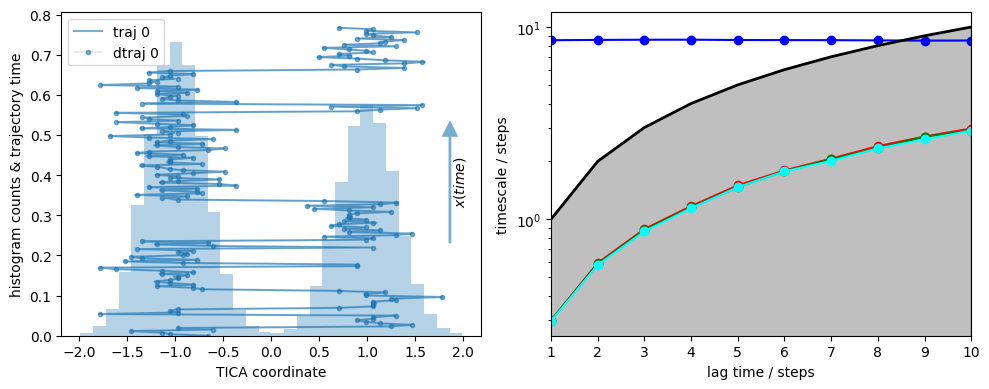

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

cluster = pyemma.coordinates.cluster_regspace(data, dmin=0.05)

plot_1D_histogram_trajectories(data, cluster=cluster, ax=axes[0])

lags = [i + 1 for i in range(10)]
its = pyemma.msm.its(cluster.dtrajs, lags=lags)
pyemma.plots.plot_implied_timescales(its, marker='o', ax=axes[1], nits=4)
fig.tight_layout()

We see a nice, reversibly connected trajectory.
That means we have sampled transitions between the basins in both directions that are correctly resolved by the discretization.
As we see from the almost perfect overlay of discrete and continuous trajectory, nearly no discretization error is made. 

###  irreversibly connected double-well trajectories

In MD simulations, we often face the problem that a process is sampled only in one direction.
For example, consider protein-protein binding.
The unbinding might take on the order of seconds to minutes and is thus difficult to sample.
We will have a look what happens with the MSM in this case. 

Our example are two trajectories sampled from a double-well potential, each started in a different basin.
They will be color coded.

In [5]:
file = mdshare.fetch('doublewell_oneway.npy', working_directory='data')
data = [trj for trj in np.load(file)]

plot_1D_histogram_trajectories(data, max_traj_length=data[0].shape[0])

error: HTTPConnectionPool(host='ftp.imp.fu-berlin.de', port=80): Max retries exceeded with url: /pub/cmb-data/doublewell_oneway.npy (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x794b13b460d0>: Failed to establish a new connection: [Errno 113] No route to host'))


ConnectionError: HTTPConnectionPool(host='ftp.imp.fu-berlin.de', port=80): Max retries exceeded with url: /pub/cmb-data/doublewell_oneway.npy (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x794b13b460d0>: Failed to establish a new connection: [Errno 113] No route to host'))

We note that the orange trajectory does not leave its potential well while the blue trajectory does overcome the barrier exactly once.

⚠️ Even though we have sampled one direction of the process,
we do not sample the way out of one of the potential wells, thus effectively finding a sink state in our data. 

Let's have a look at the MSM.
Since in higher dimensions, we often face the problem of poor discretization,
we will simulate this situation by using too few cluster centers.

In [7]:
cluster_fine = pyemma.coordinates.cluster_regspace(data, dmin=0.1)
cluster_poor = pyemma.coordinates.cluster_regspace(data, dmin=0.7)
print(cluster_fine.n_clusters, cluster_poor.n_clusters)

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_regspace". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.RegularSpace instead.
  return caller(func, *(extras + args), **kw)
/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_regspace". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.RegularSpace instead.
  return caller(func, *(extras + args), **kw)


30 5


/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


estimating MaximumLikelihoodMSM:   0%|                                     | 0/8 [00:00<?, ?it/s]

/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


estimating MaximumLikelihoodMSM:   0%|                                     | 0/8 [00:00<?, ?it/s]

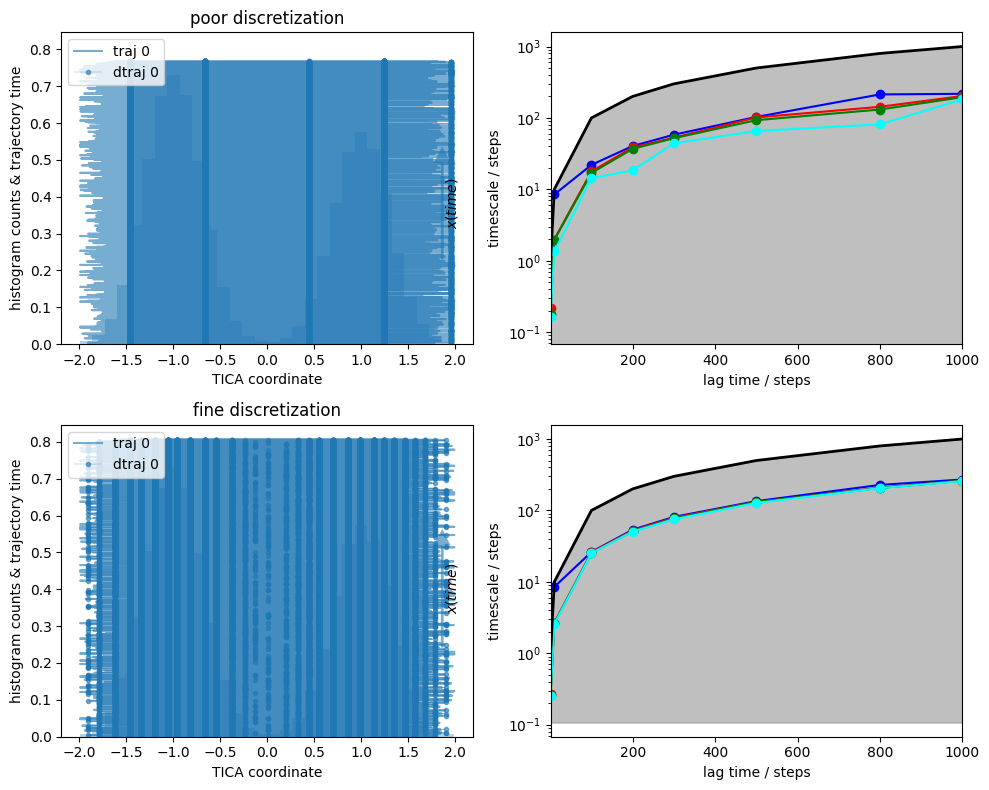

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey='col')
for cluster, ax in zip([cluster_poor, cluster_fine], axes):
    plot_1D_histogram_trajectories(data, cluster=cluster, max_traj_length=data[0].shape[0], ax=ax[0])
    its = pyemma.msm.its(cluster.dtrajs, lags=[1, 10, 100, 200, 300, 500, 800, 1000])
    pyemma.plots.plot_implied_timescales(its, marker='o', ax=ax[1], nits=4)
axes[0, 0].set_title('poor discretization')
axes[1, 0].set_title('fine discretization')
fig.tight_layout()

#### What do we see? 

1) We observe implied timescales that even look converged in the fine discretization case. 

2) With poor clustering, the process cannot be resolved any more, i.e., the ITS does not convergence before the lag time exceeds the implied time scale. 

The obvious question is, what is the process that can be observed in the fine discretization case?
PyEMMA checks for disconnectivity and thus should not find the process between the two wells.
We follow this question by taking a look at the first eigenvector, which corresponds to that process.

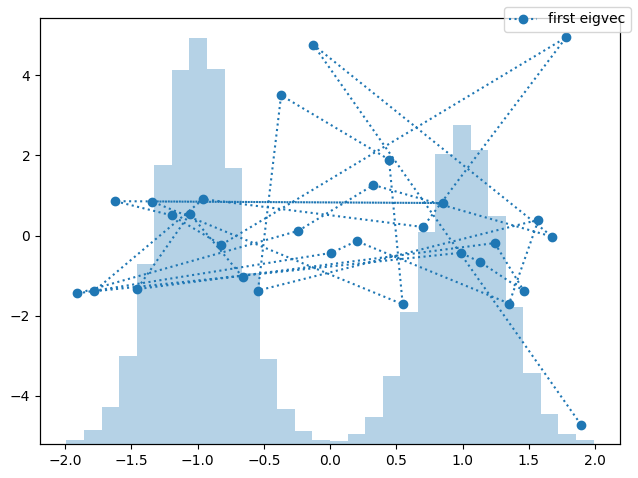

In [9]:
msm = pyemma.msm.estimate_markov_model(cluster_fine.dtrajs, 200)
fig, ax = plt.subplots()
ax.plot(
    cluster_fine.clustercenters[msm.active_set, 0],
    msm.eigenvectors_right()[:, 1],
    'o:',
    label='first eigvec')
tx = ax.twinx()
tx.hist(np.concatenate(data), bins=30, alpha=0.33)
tx.set_yticklabels([])
tx.set_yticks([])
fig.legend()
fig.tight_layout()

We observe a process which is entirely taking place in the left potential well.
How come?
PyEMMA estimates MSMs only on the largest connected set because they are only defined on connected sets.
In this particular example, the largest connected set is the microstates in the left potential well.
That means that we find a transition between the right and the left side of this well.
This is not wrong, it might just be non-informative or even irrelevant. 

The set of microstates which is used for the MSM estimation is stored in the MSM object `msm` and can be retrieved via `.active_set`.

In [10]:
print('Active set: {}'.format(msm.active_set))
print('Active state fraction: {:.2}'.format(msm.active_state_fraction))

Active set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Active state fraction: 1.0


In this example we clearly see that some states are missing.

### disconnected double-well trajectories with cross-overs

This example covers the worst-case scenario.
We have two trajectories that live in two separated wells and never transition to the other one.
Due to a very bad clustering, we believe that the data is connected.
This can happen if we cluster a large dataset in very high dimensions where it is especially difficult to debug. 

In [11]:
file = mdshare.fetch('doublewell_disconnected.npy', working_directory='data')
data = [trj for trj in np.load(file)]

plot_1D_histogram_trajectories(data, max_traj_length=data[0].shape[0])

error: HTTPConnectionPool(host='ftp.imp.fu-berlin.de', port=80): Max retries exceeded with url: /pub/cmb-data/doublewell_disconnected.npy (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x794b0c132f50>: Failed to establish a new connection: [Errno 113] No route to host'))


ConnectionError: HTTPConnectionPool(host='ftp.imp.fu-berlin.de', port=80): Max retries exceeded with url: /pub/cmb-data/doublewell_disconnected.npy (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x794b0c132f50>: Failed to establish a new connection: [Errno 113] No route to host'))

We, again, compare a reasonable to a deliberately poor discretization:

In [12]:
cluster_fine = pyemma.coordinates.cluster_regspace(data, dmin=0.1)
cluster_poor = pyemma.coordinates.cluster_regspace(data, dmin=0.7)
print(cluster_fine.n_clusters, cluster_poor.n_clusters)

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_regspace". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.RegularSpace instead.
  return caller(func, *(extras + args), **kw)
/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_regspace". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.RegularSpace instead.
  return caller(func, *(extras + args), **kw)


30 5


/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


estimating MaximumLikelihoodMSM:   0%|                                     | 0/8 [00:00<?, ?it/s]

/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


estimating MaximumLikelihoodMSM:   0%|                                     | 0/8 [00:00<?, ?it/s]

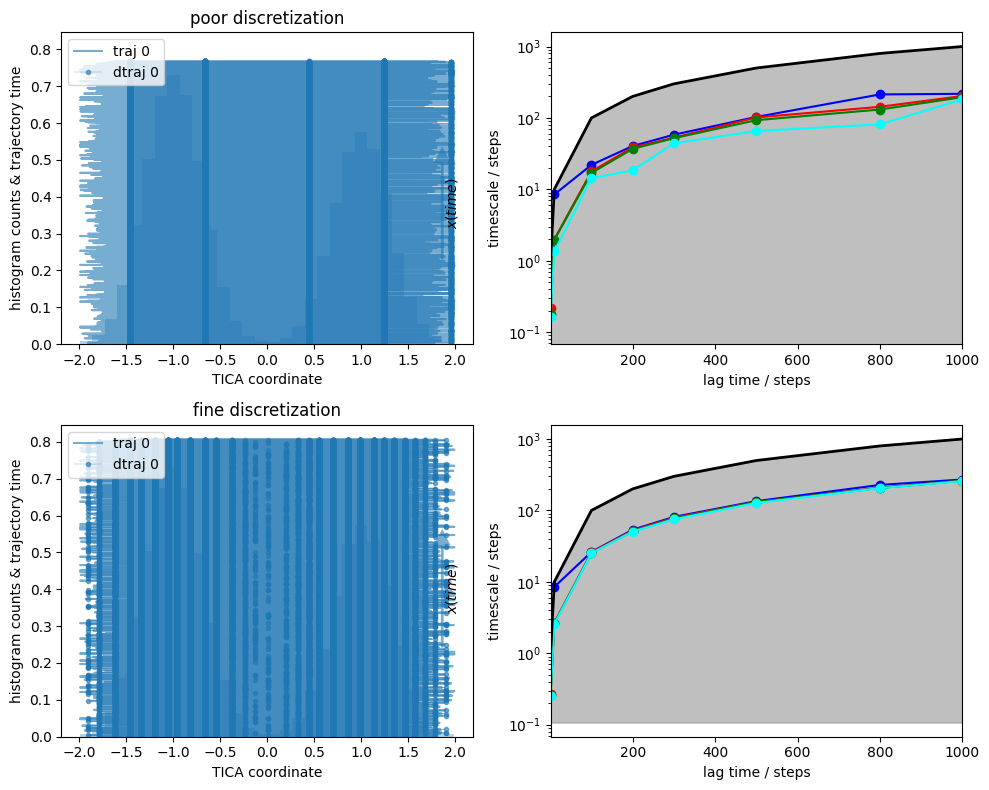

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey='col')
for cluster, ax in zip([cluster_poor, cluster_fine], axes):
    plot_1D_histogram_trajectories(data, cluster=cluster, max_traj_length=data[0].shape[0], ax=ax[0])
    its = pyemma.msm.its(cluster.dtrajs, lags=[1, 10, 100, 200, 300, 500, 800, 1000])
    pyemma.plots.plot_implied_timescales(its, marker='o', ax=ax[1], nits=4)
axes[0, 0].set_title('poor discretization')
axes[1, 0].set_title('fine discretization')
fig.tight_layout()

#### What do we see?

1) With the fine discretization, we observe some timescales that are converged. These are most probably processes within one of the wells, similar to the ones we saw before.

2) The poor discretization induces a large error and describes artificial short visits to the other basin.

3) The timescales in the poor discretization are much higher but not converged. 

The reason for the high timescales in 3) are in fact the artificial cross-over events created by the poor discretization.
This process was not actually sampled and is an artifact of bad clustering.
Let's look at it in more detail and see what happens if we estimate an MSM and even compute metastable states with PCCA++.

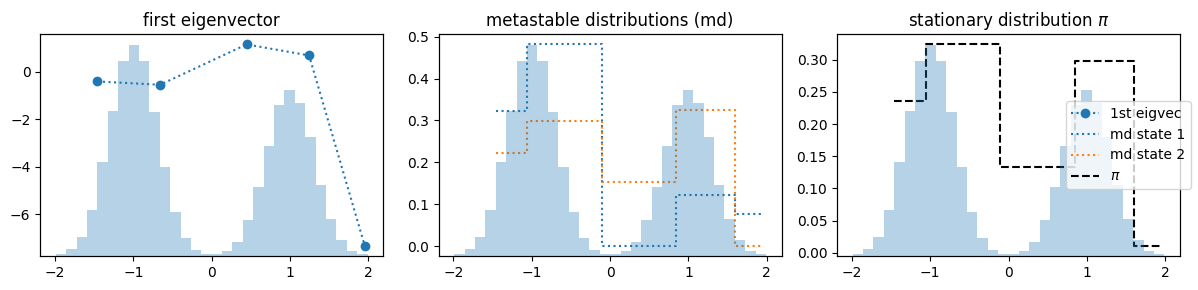

In [14]:
msm = pyemma.msm.estimate_markov_model(cluster_poor.dtrajs, 200)

nstates = 2
msm.pcca(nstates)

index_order = np.argsort(cluster_poor.clustercenters[:, 0])

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].plot(
    cluster_poor.clustercenters[index_order, 0],
    msm.eigenvectors_right()[index_order, 1],
    'o:',
    label='1st eigvec')
axes[0].set_title('first eigenvector')
for n, metastable_distribution in enumerate(msm.metastable_distributions):
    axes[1].step(
        cluster_poor.clustercenters[index_order, 0],
        metastable_distribution[index_order],
        ':', 
        label='md state {}'.format(n + 1),
        where='mid')
axes[1].set_title('metastable distributions (md)')
axes[2].step(
    cluster_poor.clustercenters[index_order, 0],
    msm.pi[index_order],
    'k--',
    label='$\pi$',
    where='mid')
axes[2].set_title('stationary distribution $\pi$')
for ax in axes:
    tx = ax.twinx()
    tx.hist(np.concatenate(data), bins=30, alpha=0.33)
    tx.set_yticklabels([])
    tx.set_yticks([])
fig.legend(loc=7)
fig.tight_layout()

We observe that the first eigenvector represents a process that does not exist, i.e., is an artifact.
Nevertheless, the PCCA++ algorithm can separate metastable states in a way we would expect.
It finds the two disconnected states. However, the stationary distribution yields arbitrary results. 

#### How to detect disconnectivity?

Generally, hidden Markov models (HMMs) are much more reliable because they come with an additional layer of hidden states.
Cross-over events are thus unlikely to be counted as "real" transitions.
Thus, it is a good idea to estimate an HMM.
What happens if we try to estimate a two state HMM on the same, poorly discretized data? 

⚠️ It is important to note that the HMM estimation is initialized from the PCCA++ metastable states that we already analyzed.

In [15]:
hmm = pyemma.msm.estimate_hidden_markov_model(cluster_poor.dtrajs, nstates, msm.lag)

We are getting an error message which already explains what is going wrong, i.e.,
that the (macro-) states are not connected and thus no unique stationary distribution can be estimated.
This is equivalent to having two eigenvalues of magnitude 1 or an implied timescale of infinity which is what we observe in the implied timescales plot.

estimating MaximumLikelihoodHMSM:   0%|                                    | 0/5 [00:00<?, ?it/s]

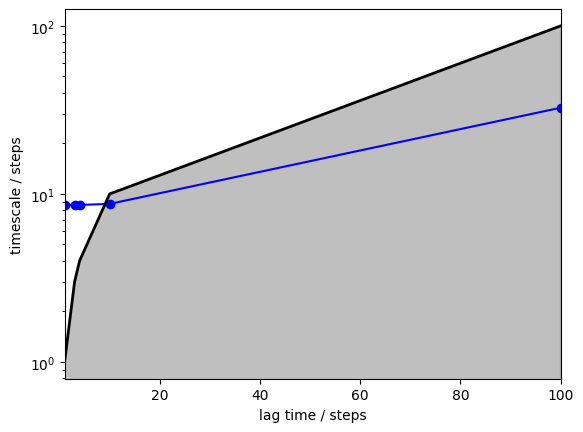

In [16]:
its = pyemma.msm.timescales_hmsm(cluster_poor.dtrajs, nstates, lags=[1, 3, 4, 10, 100])
pyemma.plots.plot_implied_timescales(its, marker='o', ylog=True);

As we see, the requested timescales above $4$ steps could not be computed because the underlying HMM is disconnected,
i.e., the corresponding timescales are infinity.
The implied timescales that could be computed are most likely the same process that we observed from the fine clustering before, i.e., jumps within one basin.

In general, it is a non-trivial problem to show that processes were not sampled reversibly.
In our experience, HMMs are a good choice here, even though situations can occur where they might not detect the problem as easily as in this example. 

<a id="poorly_sampled_dw"></a>
### poorly sampled double-well trajectories

Let's now assume that everything worked out fine but our sampling is somewhat poor.
This is a realistic scenario when dealing with large systems that were well-sampled but still contain only few events of interest.
We expect that our trajectories are just long enough to sample a certain process but are too short to capture them with a large lag time.
To rule out discretization issues and to make the example clear, we use the full data set for discretization.

In [17]:
file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = [fh['trajectory'][:, 1]]
cluster = pyemma.coordinates.cluster_regspace(data, dmin=0.05)

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_regspace". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.RegularSpace instead.
  return caller(func, *(extras + args), **kw)


We want to simulate a process that happens on a timescale that is on the order of magnitude of the trajectory length.
To do so, we choose `n_trajs` chunks from the full data set that contain `traj_length` steps by splitting the original trajectory:

In [18]:
traj_length = 10
n_trajs = 50

data_short_trajs = list(data[0].reshape((data[0].shape[0] // traj_length, traj_length)))[:n_trajs]
dtrajs_short = list(cluster.dtrajs[0].reshape((data[0].shape[0] // traj_length, traj_length)))[:n_trajs]

/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Now, let's plot the trajectories (left panel) and estimate implied timescales (right panel) as above.
Since we know the true ITS of this process, we visualize it as a dotted line.

estimating MaximumLikelihoodMSM:   0%|                                     | 0/9 [00:00<?, ?it/s]

07-03-25 10:29:45 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[26] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


estimating MaximumLikelihoodMSM:   0%|                                     | 0/9 [00:00<?, ?it/s]

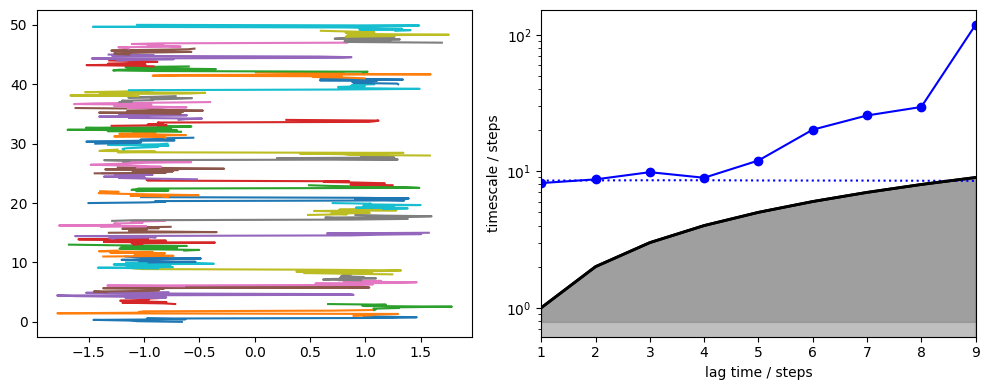

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for n, _traj in enumerate(data_short_trajs):
    axes[0].plot(_traj, np.linspace(0, 1, _traj.shape[0]) + n)

lags = [i + 1 for i in range(9)]

its = pyemma.msm.its(dtrajs_short, lags=lags)
pyemma.plots.plot_implied_timescales(its, marker='o', ax=axes[1], nits=1)
its_reference = pyemma.msm.its(cluster.dtrajs, lags=lags)
pyemma.plots.plot_implied_timescales(its_reference, linestyle=':', ax=axes[1], nits=1)
fig.tight_layout()

We note that the slowest process is clearly contained in the data chunks and is reversibly sampled (left panel, short trajectory pieces color coded and stacked).
Due to very short trajectories, we find that this process can only be captured at a very short MSM lag time (right panel).
Above that interval, the slowest timescale diverges.
Luckily, here we know that it is already converged at $\tau = 1$, so we estimate an MSM:

In [20]:
msm_short_trajectories = pyemma.msm.estimate_markov_model(dtrajs_short, 1)

Let's now have a look at the CK-test:

estimating MaximumLikelihoodMSM:   0%|                                     | 0/9 [00:00<?, ?it/s]

/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_api.py:256: UserWarning: truncated eigendecomposition to contain 43 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_api.py:256: UserWarning: truncated eigendecomposition to contain 42 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_api.py:256: UserWarning: truncated eigendecomposition to contain 38 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_api.py:256: UserWarning: truncated eigendecomposition to contain 35 components
  warnings.warn('truncated eigendecomposition to co

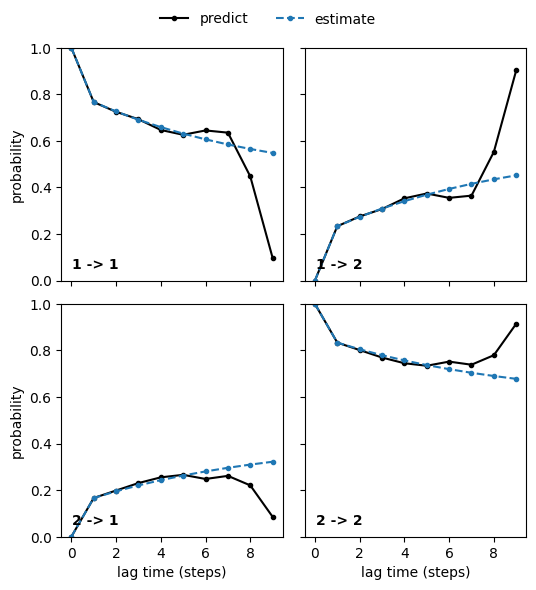

In [21]:
pyemma.plots.plot_cktest(msm_short_trajectories.cktest(2), marker='.');

As already discussed, we cannot expect new estimates above a certain lag time to agree with the model prediction due to too short trajectories.
Indeed, we find that new estimates and model predictions diverge at very high lag times.
This does not necessarily mean that the model at $\tau=1$ is wrong and in this particular case,
we can even explain the divergence and find that it fits to the implied timescales divergence. 

This example mirrors another incarnation of the sampling problem: Working with large systems,
we often have comparably short trajectories with few rare events.
Thus, implied timescales convergence can often be achieved only in a certain interval and CK-tests will not converge up to arbitrary multiples of the lag time.
It is the responsibility of the modeler to interpret these results and to ensure that a valid model can be obtained from the data.

Please note that this is only a special case of a failed CK test.
More general information about CK tests and what it means if it fails are explained in
[Notebook 03 ➜ 📓](03-msm-estimation-and-validation.ipynb).

## Case 2: low-dimensional molecular dynamics data (alanine dipeptide)

In this example, we will show how an ill-conducted TICA analysis can yield results that look metastable in the 2D histogram,
but in fact are not describing the slow dynamics.
Please note that this was deliberately broken with a nonsensical TICA-lagtime of almost trajectory length, which is 250 ns.

We start off with adding all atom coordinates.
That is a non-optimal choice because it artificially blows up the dimensionality,
but might still be a reasonable choice depending on the problem.
A well-conducted TICA projection can extract the slow coordinates, as we will see at the end of this example.

In [22]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')
feat = pyemma.coordinates.featurizer(pdb)

feat.add_all()
data = pyemma.coordinates.load(files, features=feat)

Obtaining file info:   0%|                                                 | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                                     | 0/3 [00:00<?, ?it/s]

TICA analysis is conducted with an extremely high lag time of almost $249.9$ ns. We map down to two dimensions.

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|                                               | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|                                              | 0/3 [00:00<?, ?it/s]

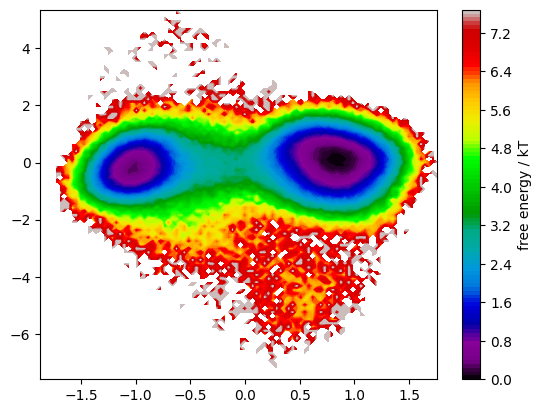

In [23]:
tica = pyemma.coordinates.tica(data, lag=data[0].shape[0] - 100, dim=2)
tica_output = tica.get_output()

pyemma.plots.plot_free_energy(*np.concatenate(tica_output).T, legacy=False);

In the free energy plot, we recognize two defined basins that are nicely separated by the first TICA component. We thus continue with a discretization of this space and estimate MSM implied timescales.

In [24]:
cluster = pyemma.coordinates.cluster_kmeans(tica_output, k=200, max_iter=30, stride=100)

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                                       | 0/200 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                  | 0/30 [00:00<?, ?it/s]

07-03-25 10:29:55 pyemma.coordinates.clustering.kmeans.KmeansClustering[37] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 30 iterations. Consider increasing max_iter.


/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 30 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


getting output of KmeansClustering:   0%|                                  | 0/3 [00:00<?, ?it/s]

estimating MaximumLikelihoodMSM:   0%|                                     | 0/6 [00:00<?, ?it/s]

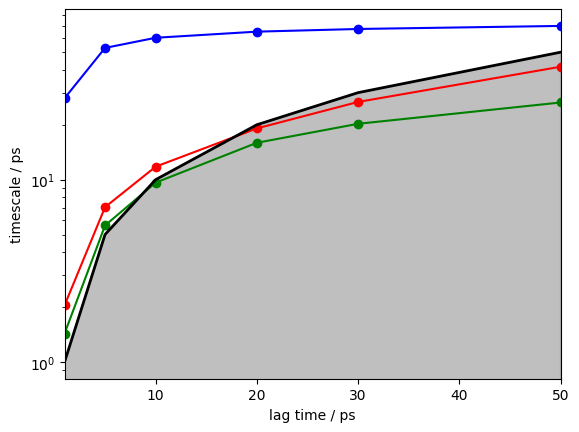

In [25]:
its = pyemma.msm.its(cluster.dtrajs, lags=[1, 5, 10, 20, 30, 50])
pyemma.plots.plot_implied_timescales(its, marker='o', units='ps', nits=3);

Indeed, we observe a converged implied timescale.
In this example we already know that it is way lower than expected,
but in the general case we are unaware of the real dynamics of the system. 

Thus, we estimate an MSM at lag time $20 $ ps.
Coarse graining and validation will be done with $2$ metastable states since we found $2$ basins in the free energy landscape and have one slow process in the ITS plot.

In [26]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, 20)

nstates = 2
msm.pcca(nstates);

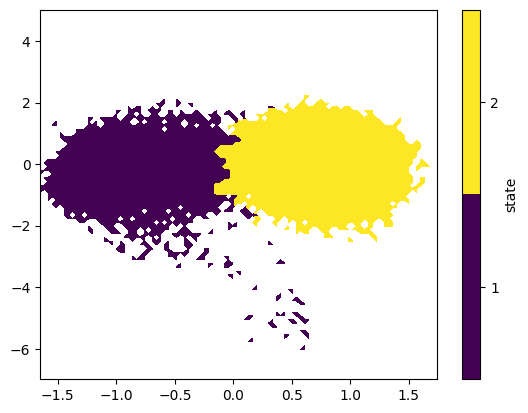

In [27]:
stride = 10
metastable_trajs_strided = [msm.metastable_assignments[dtrj[::stride]] for dtrj in cluster.dtrajs]
tica_output_strided = [i[::stride] for i in tica_output]
_, _, misc = pyemma.plots.plot_state_map(*np.concatenate(tica_output_strided).T, 
                                         np.concatenate(metastable_trajs_strided));
misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates

As we see, the PCCA++ algorithm is perfectly able to separate the two basins.
Let's go on with a Chapman-Kolmogorow validation.

estimating MaximumLikelihoodMSM:   0%|                                     | 0/9 [00:00<?, ?it/s]

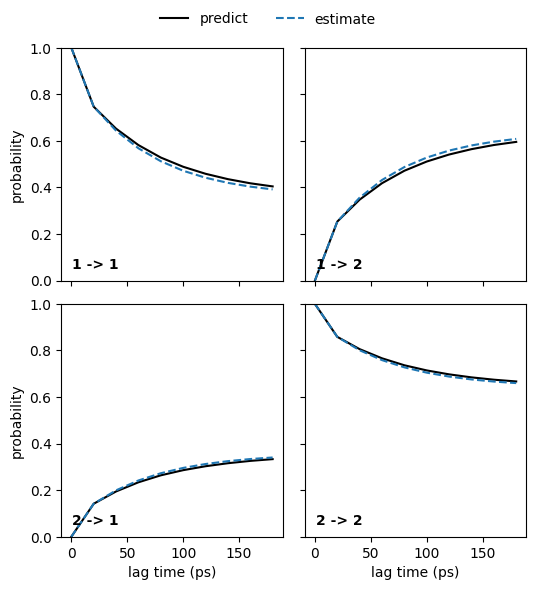

In [28]:
pyemma.plots.plot_cktest(msm.cktest(nstates), units='ps');

Congratulations, we have estimated a well-validated MSM.
The only question remaining is: What does it actually describe?
For this, we usually extract representative structures as described in [Notebook 00 ➜ 📓](00-pentapeptide-showcase.ipynb).
We will not do this here but look at the metastable trajectories instead.

#### What could be wrong about it?

Let's have a look at the trajectories as assigned to PCCA++ metastable states.
We have already computed them before but not looked at their time dependence.

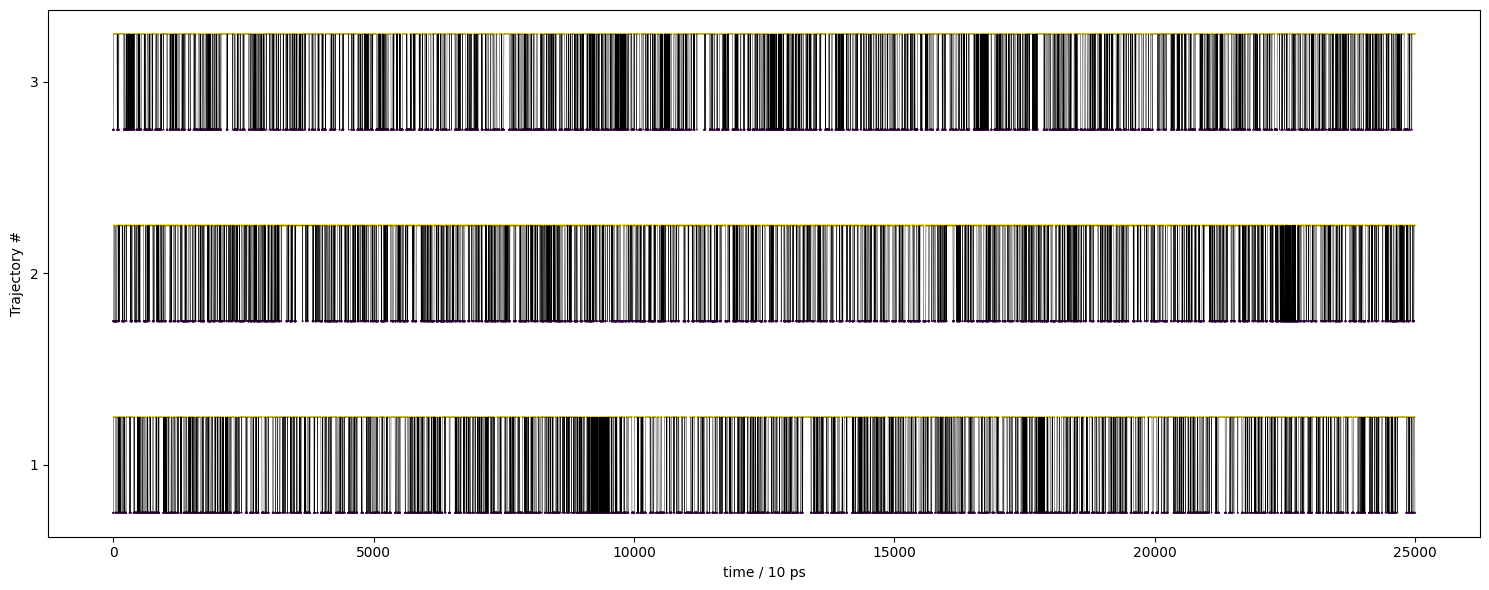

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), sharey=True, sharex=True)
ax_yticks_labels = []
for n, pcca_traj in enumerate(metastable_trajs_strided):
    ax.plot(range(len(pcca_traj)), msm.n_metastable * n + pcca_traj, color='k', linewidth=0.3)
    ax.scatter(range(len(pcca_traj)), msm.n_metastable * n + pcca_traj, c=pcca_traj, s=0.1)
    ax_yticks_labels.append(((msm.n_metastable * (2 * n + 1) - 1) / 2, n + 1))
ax.set_yticks([l[0] for l in ax_yticks_labels])
ax.set_yticklabels([str(l[1]) for l in ax_yticks_labels])
ax.set_ylabel('Trajectory #')
ax.set_xlabel('time / {} ps'.format(stride))
fig.tight_layout()

#### What do we see?
The above figure shows the metastable states visited by the trajectory over time.
Each metastable state is color-coded, the trajectory is shown by the black line.
This is clearly not a metastable trajectory as we would have expected. 

What did we do wrong?
Let's have a look at the TICA trajectories, not only the histogram!

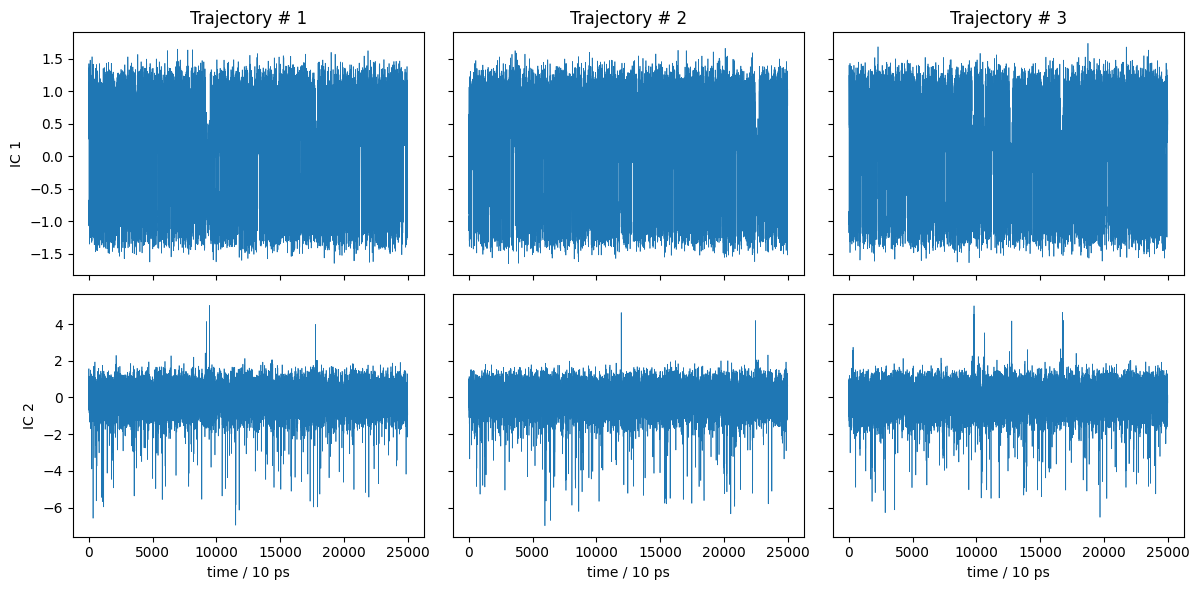

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey='row')

for n, trj in enumerate(tica_output):
    for dim, traj1d in enumerate(trj.T):
        axes[dim, n].plot(traj1d[::stride], linewidth=.5)
for ax in axes[1]:
    ax.set_xlabel('time / {} ps'.format(stride))
for dim, ax in enumerate(axes[:, 0]):
    ax.set_ylabel('IC {}'.format(dim + 1))
for n, ax in enumerate(axes[0]):
    ax.set_title('Trajectory # {}'.format(n + 1))
fig.tight_layout()

This is essentially noise, so it is not surprising that the metastable trajectories do not show significant metastability.
The MSM nevertheless found a process in the above TICA components which, however,
does not seem to describe any of the slow dynamics.
Thus, the model is not wrong, it is just not informative. 

As we see in this example, it can be instructive to keep the trajectories in mind and not to rely on the histograms alone.

⚠️ Histograms are no proof of metastability,
they can only give us a hint towards defined states in a multi-dimensional state space which can be metastable.

#### How to fix it?

In this particular example, we already know the issue:
the TICA lag time was deliberately chosen way too high.
That's easy to fix.

Let's now have a look at how the metastable trajectories should look for a decent model such as the one estimated in [Notebook 05 ➜ 📓](05-pcca-tpt.ipynb).
We will take the same input data,
do a TICA transform with a realistic lag time of $10$ ps,
and coarse grain into $2$ metastable states in order to compare with the example above.

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|                                               | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|                                              | 0/3 [00:00<?, ?it/s]

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                                       | 0/200 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                  | 0/30 [00:00<?, ?it/s]

07-03-25 10:30:06 pyemma.coordinates.clustering.kmeans.KmeansClustering[47] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 30 iterations. Consider increasing max_iter.


/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 30 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


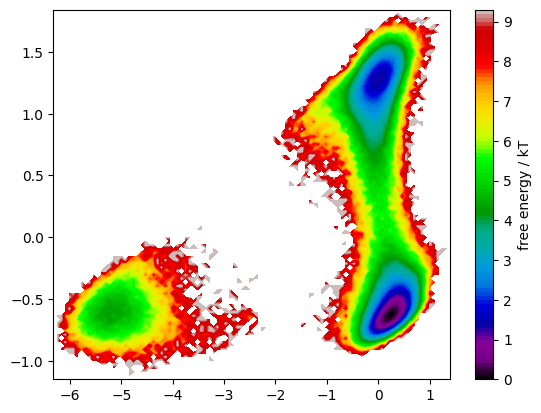

In [31]:
tica = pyemma.coordinates.tica(data, lag=10, dim=2)
tica_output = tica.get_output()
cluster = pyemma.coordinates.cluster_kmeans(tica_output, k=200, max_iter=30, stride=100)

pyemma.plots.plot_free_energy(*np.concatenate(tica_output).T, legacy=False);

As wee see, TICA yields a very nice state separation.
We will see that these states are in fact metastable.

In [32]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=20)
msm.pcca(nstates);

/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


getting output of KmeansClustering:   0%|                                  | 0/3 [00:00<?, ?it/s]

In [33]:
metastable_trajs_strided = [msm.metastable_assignments[dtrj[::stride]] for dtrj in cluster.dtrajs]

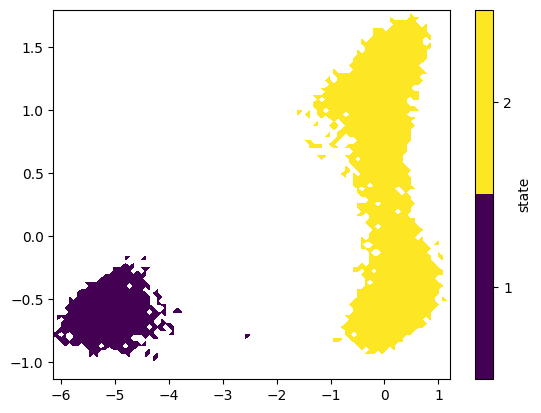

In [34]:
stride = 10
tica_output_strided = [i[::stride] for i in tica_output]
_, _, misc = pyemma.plots.plot_state_map(*np.concatenate(tica_output_strided).T, 
                                         np.concatenate(metastable_trajs_strided));
misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates

We note that PCCA++ separates the two basins of the free energy plot.
Let's have a look at the metastable trajectories:

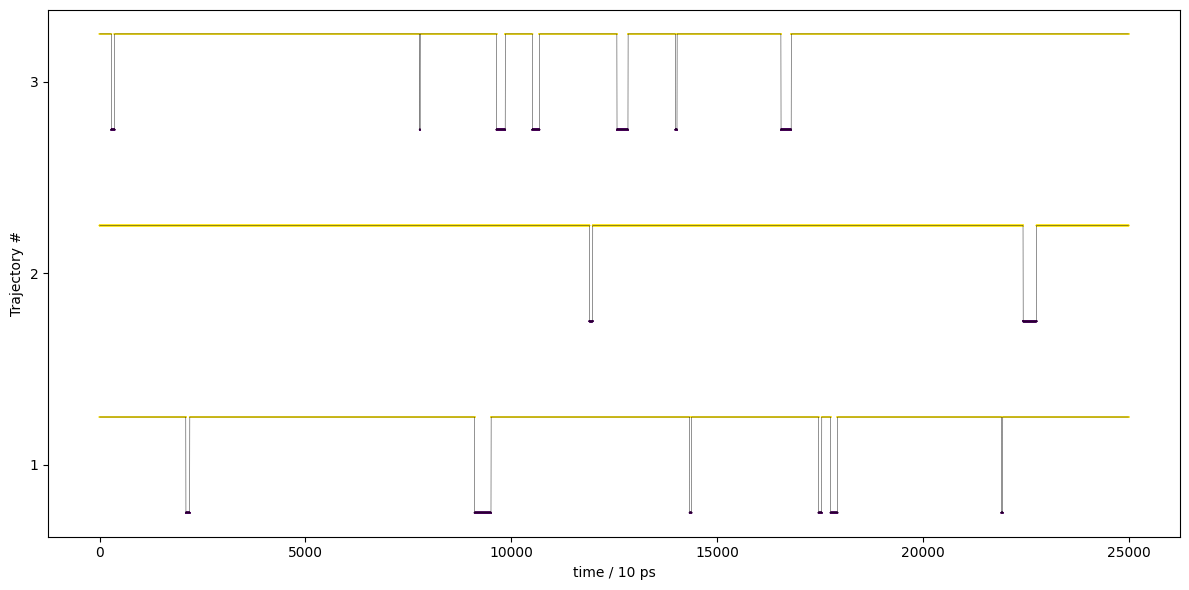

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharey=True, sharex=True)
ax_yticks_labels = []
for n, pcca_traj in enumerate(metastable_trajs_strided):
    ax.plot(range(len(pcca_traj)), msm.n_metastable * n + pcca_traj, color='k', linewidth=0.3)
    ax.scatter(range(len(pcca_traj)), msm.n_metastable * n + pcca_traj, c=pcca_traj, s=0.1)
    ax_yticks_labels.append(((msm.n_metastable * (2 * n + 1) - 1) / 2, n + 1))
ax.set_yticks([l[0] for l in ax_yticks_labels])
ax.set_yticklabels([str(l[1]) for l in ax_yticks_labels])
ax.set_ylabel('Trajectory #')
ax.set_xlabel('time / {} ps'.format(stride))
fig.tight_layout()

These trajectories show the expected behavior of a metastable trajectory,
i.e., it does not quickly jump back and forth between the states.

## Wrapping up

In this notebook, we have learned about some problems that can arise when estimating MSMs with "real world" data at simple examples.
In detail, we have seen
- irreversibly connected dynamics and what it means for MSM estimation,
- fully disconnected trajectories and how to identify them,
- connected but poorly sampled trajectories and how convergence looks in this case,
- ill-conducted TICA analysis and what it yields.

The most important lesson from this tutorial is that histograms, which are usually calculated in a projected space, are not a sufficient means of identifying metastability or connectedness.
It is crucial to remember that the underlying trajectories play the role of ground truth for the model. 
Ultimately, histograms only help us to understand this ground truth but cannot provide a complete picture.